# Исследование закономерности определяющие успешность видеоигры.
 Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. Данные до 2016 года. 

Перед нами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и мы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. 

## Общая нформация.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st

In [2]:
games = pd.read_csv('/datasets/games.csv')#открываем файл
games.info()#посмотрим типы данных и количество ненулевых значений

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [3]:
display(games.head(10), str(pd.set_option('display.max_columns', None)))#выводим первые 10 строк таблицы
#увеличиваем максимальное количество отображающихся столбцов

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


'None'

In [4]:
#Посмотрим, какие жанры игр мы имеем, и нет ли у нас повторений.
games['Genre'].value_counts()

Action          3369
Sports          2348
Misc            1750
Role-Playing    1498
Shooter         1323
Adventure       1303
Racing          1249
Platform         888
Simulation       873
Fighting         849
Strategy         683
Puzzle           580
Name: Genre, dtype: int64

In [5]:
games.duplicated().sum()#проверим на наличие дубликатов

0

Итак, в таблице 11 столбцов.
Согласно документации к данным:
 *   Name — название игры
 *   Platform — платформа
 *   Year_of_Release — год выпуска
 *   Genre — жанр игры
 *   NA_sales — продажи в Северной Америке (миллионы проданных копий)
 *   EU_sales — продажи в Европе (миллионы проданных копий)
 *   JP_sales — продажи в Японии (миллионы проданных копий)
 *   Other_sales — продажи в других странах (миллионы проданных копий)
 *   Critic_Score — оценка критиков (максимум 100)
 *   User_Score — оценка пользователей (максимум 10)
 *   Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.
 
 У столбца Year_of_Release тип float64, должен быть Int64.
 User_Score имеет тип object - меняем на float.
 
 Количество значений в столбцах различается. Значит, в данных есть пропущенные значения.

In [6]:
games.isna().sum() #количество пропущенных значений для каждого столбца

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

Столбец Year_of_Release имеет 1,6% пропусков. Средними/медианами эти пропуски не заполнить, эти данные не являются самыми важными для анализа данных, да и пропусков в столбце не так много.

## Предобработка данных.

In [7]:
games.columns # перечень названий столбцов таблицы

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

In [8]:
# Заменим названия столбцов (приведем к нижнему регистру)
games.columns = games.columns.str.lower()

In [9]:
games.columns# проверка результатов - перечень названий столбцов

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [10]:
# Приведем к нижнему регистру следующие столбцы:
for column in games[['name','platform','genre','rating']]:
    games[column] = games[column].str.lower()

In [11]:
# Изменим тип данных в столбце year_of_release 
games['year_of_release'] = games['year_of_release'].astype('Int64')

In [12]:
games['user_score'].unique() # Посмотрим отдельно столбцы user_score

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Помимо пропусков, видим "tbd". Посмотрим, сколько их там таких:

In [13]:
games[games['user_score'] == 'tbd']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,zumba fitness,wii,2010,sports,3.45,2.59,0.0,0.66,NaN,tbd,e
301,namco museum: 50th anniversary,ps2,2005,misc,2.08,1.35,0.0,0.54,61.0,tbd,e10+
520,zumba fitness 2,wii,2011,sports,1.51,1.03,0.0,0.27,NaN,tbd,t
645,udraw studio,wii,2010,misc,1.65,0.57,0.0,0.20,71.0,tbd,e
657,frogger's adventures: temple of the frog,gba,<NA>,adventure,2.15,0.18,0.0,0.07,73.0,tbd,e
...,...,...,...,...,...,...,...,...,...,...,...
16695,planet monsters,gba,2001,action,0.01,0.00,0.0,0.00,67.0,tbd,e
16697,bust-a-move 3000,gc,2003,puzzle,0.01,0.00,0.0,0.00,53.0,tbd,e
16698,mega brain boost,ds,2008,puzzle,0.01,0.00,0.0,0.00,48.0,tbd,e
16704,plushees,ds,2008,simulation,0.01,0.00,0.0,0.00,NaN,tbd,e


2424 строк с такм значением.

'To Be Determined' - 'Будет определено'. Т.е. это то же самое, что неизвестное значение. Поэтому, можно смело заменить значение 'tbd' на 'NaN'.

In [14]:
#Заменим tbd на NaN
games['user_score'] = games['user_score'].replace('tbd', np.nan)

In [15]:
games['user_score'] = games['user_score'].astype('float') # Поменяем формат столбца user_score на float

Столбец name имеет всего 2 пропуска из всего датафрейма и эти данные невозможно заполнить, то считаю возможным удалить строки с данными пропусками.

In [16]:
games = games.dropna(subset=['name'])#удаляем пропущенные значения

In [17]:
games['year_of_release'].isna().sum() # Посчитаем количество пустых значений в столбце year_of_release

269

In [18]:
display(games[games['year_of_release'].isna()].head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,madden nfl 2004,ps2,<NA>,sports,4.26,0.26,0.01,0.71,94.0,8.5,e
377,fifa soccer 2004,ps2,<NA>,sports,0.59,2.36,0.04,0.51,84.0,6.4,e
456,lego batman: the videogame,wii,<NA>,action,1.80,0.97,0.00,0.29,74.0,7.9,e10+
475,wwe smackdown vs. raw 2006,ps2,<NA>,fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,space invaders,2600,<NA>,shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN


In [19]:
games.query('name == "madden nfl 2004"')# Возьмем одну из 269 игр с неуказанным годом и проверим, 
#выпускалась ли она на других платформах.

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,madden nfl 2004,ps2,<NA>,sports,4.26,0.26,0.01,0.71,94.0,8.5,e
1881,madden nfl 2004,xb,2003,sports,1.02,0.02,0.00,0.05,92.0,8.3,e
3889,madden nfl 2004,gc,2003,sports,0.40,0.10,0.00,0.01,94.0,7.7,e
5708,madden nfl 2004,gba,2003,sports,0.22,0.08,0.00,0.01,70.0,6.6,e


In [20]:
# Можно попробовать восполнить пробелы в годах за счет наличия в датасете информации об одних и тех же играх, 
#только выпущенных для разных платформ (если у какой-то из версий игры будет запись о годе)
for i in games[games['year_of_release'].isnull() == True].index:  
    games['year_of_release'][i] = games.loc[games['name'] == games['name'][i], 'year_of_release'].max()

In [21]:
games['year_of_release'].isna().sum()

146

В столбце year_of_release осталось 146 пропусков. 

Столбцы 'critic_score' и 'user_score'

Крупнейшие платформы, освещающие рынок игр, стали появляться во второй половине 90-х (IGN - 1996, Igromania - 1997, Metacritic - 1998). Таким образом, вполне вероятно, что далеко не всем играм, выпущенным до 1996 года, критики ставили оценки. То же самое справедливо и для столбца 'user_score'. Ведь оценки играм пользователям нужно было где-то размещать в сети. Также, так как данные не за полный 2016 год, то и там логично наблюдать пустые значения.

Столбец 'raiting'

Крупнейшая негосударственная организация (ESRB), присуждающая рейтинги играм была основана в 1994 году. Соответственно, далеко не всем играм, выпущенным до этого года, присуждался рейтинг.

In [22]:
games['rating'] = games['rating'].fillna('unknown') # Заполним отсутствующие значения столбца rating словом 'unknown'

У нас к обработке столбцы critic_score и user_score - заполним пропуски значением -1.

In [25]:
games['total_sales'] = games[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

## Исследовательский анализ данных

Посмотрим, сколько игр выпускалось в разные годы.

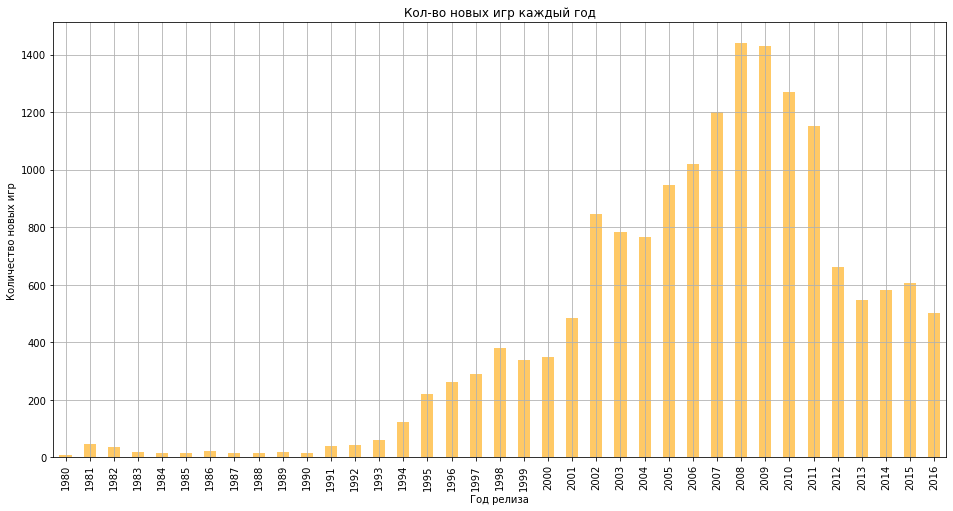

In [26]:
(
    games
    .pivot_table(index='year_of_release', values='name', aggfunc='count')
    .plot(y='name', kind='bar', figsize=(16, 8), title='Кол-во новых игр каждый год', grid=True, color='orange', alpha=0.6, legend=False)
    .set(xlabel='Год релиза', ylabel='Количество новых игр')
)
plt.show()

До 1994 года и Pentium 1 игр практически не было. Потом они начали появляться, сначала на MS-DOS, потом уже на Windows. Резкий скачок по количеству игр, выпущенных в год, произошел в 2002 году. Пик - 2008-2009 года. После этого начался спад, связанный с развитием мобильных устройств, интеграция соц. сетей в жизнь людей. Это всё привело к тому, что интерес к самим играм упал, соответственно, упало и их производство.

Посмотрим, как менялись продажи по платформам.

Text(0, 0.5, 'Количество продаж')

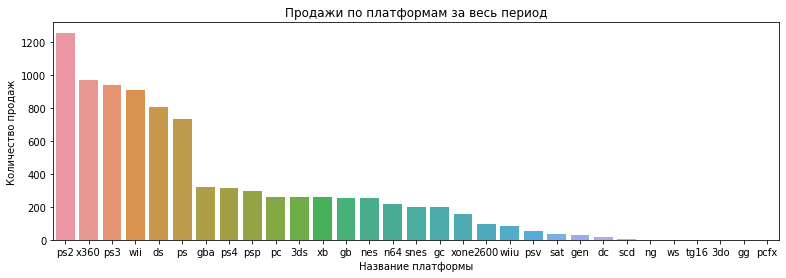

In [27]:
sales_on_platform = games.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(
    by='total_sales', ascending=False)

plt.figure(figsize=(13,4))
sns.barplot(x=sales_on_platform.index,y=sales_on_platform['total_sales'])
plt.title("Продажи по платформам за весь период")
plt.xlabel("Название платформы")
plt.ylabel("Количество продаж")

Лидером является платформа PS2. Далее идут X360, PS3, Wii, DS и PS.

In [28]:
# Сформируем 6 df для каждой платформы (объём продаж под каждую платформу в каждый год)
PS2 = games.query('platform =="ps2"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
X360 = games.query('platform =="x360"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
PS3 = games.query('platform =="ps3"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
Wii = games.query('platform =="wii"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
DS = games.query('platform =="ds"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
PS = games.query('platform =="ps"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')

In [29]:
# Создадим сводную таблицу, где для каждой платформы указан ежегодный объём продаж
top6_platform = (
    PS.merge(PS2, how='outer', on='year_of_release')
    .merge(X360, how='outer', on='year_of_release')
    .merge(PS3, how='outer', on='year_of_release')
    .merge(Wii, how='outer', on='year_of_release')
    .merge(DS, how='outer', on='year_of_release')
)

In [30]:
# Переименовываем названия столбцов для убобства
top6_platform.set_axis(['PS', 'PS2', 'X360', 'PS3', 'Wii', 'DS'], axis = 'columns', inplace = True)
top6_platform = top6_platform.query('year_of_release >= 1994').fillna(0) # Пропуски заменяем на 0, 
#фильтруем значения от 2000 года и выше


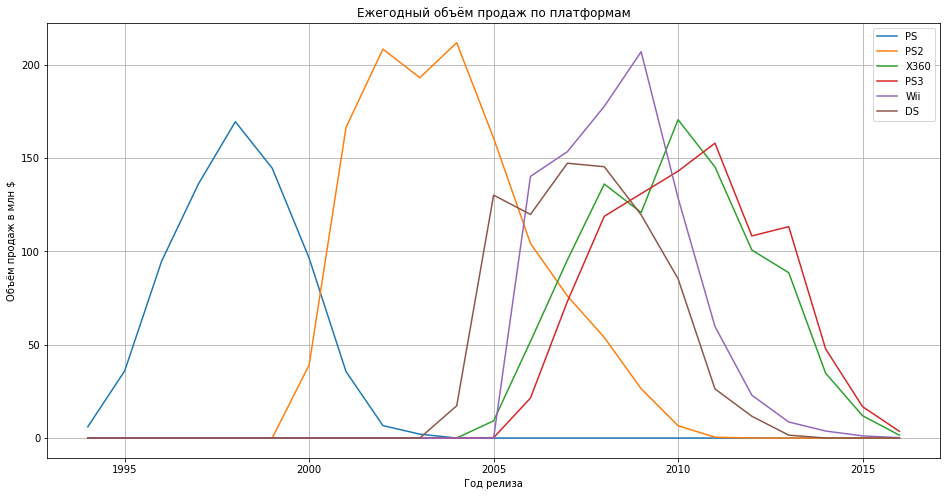

In [31]:
# Рисую гистограмму для визуального анализа полученных результатов
top6_platform.plot(figsize=(16, 8), title='Ежегодный объём продаж по платформам', grid=True).set(xlabel='Год релиза', ylabel='Объём продаж в млн $')
plt.show()

Посмотрим, сколько "живут" платформы для видеоигр:

    PS - существовала с 1994 года до 2003 - 9 лет;
    PS2 - с 2000 до 2011 года - 11 лет;
    PS3 - с 2006 по настоящее время ещё живёт, но начала сильно сдавать позиции с выходом в 2013 году PS4;
    DS - вышла в 1985, потом вообще нет данных, скорее всего, по той причине, что они не собирались. И с 2004 года популярность стала расти, пик в 2008, конец срока службы - 2013 год - 8 активных лет жизни;
    Wii - с 2006 по нынешний день, но в 2016 уже почти изжила себя - опять 10 лет;
    X360 с 2005 по 2016 - 11 лет.

Таким образом, в среднем платформы для видеогр существуют 10 лет. В среднем актвные продажи платформ длятся 5 лет.


<div class="alert alert-info">
<b></b>
<br>Для прогноза на 2017 год за актуальный период возьмем последние 3 года (2014-2016гг.).
</div>

In [104]:
# Построим ещё один график, отображающий динамику продаж по уже актуальным годам
decline_period_data = games[games['year_of_release'] > 2013]
decline_period_data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,call of duty: black ops 3,ps4,2015,shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,14.63
42,grand theft auto v,ps4,2014,action,3.96,6.31,0.38,1.97,97.0,8.3,m,12.62
47,pokemon omega ruby/pokemon alpha sapphire,3ds,2014,role-playing,4.35,3.49,3.10,0.74,NaN,NaN,unknown,11.68
77,fifa 16,ps4,2015,sports,1.12,6.12,0.06,1.28,82.0,4.3,e,8.58
87,star wars battlefront (2015),ps4,2015,shooter,2.99,3.49,0.22,1.28,NaN,NaN,unknown,7.98
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,strawberry nauts,psv,2016,adventure,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01
16707,aiyoku no eustia,psv,2014,misc,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01
16710,samurai warriors: sanada maru,ps3,2016,action,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01
16712,haitaka no psychedelica,psv,2016,adventure,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01


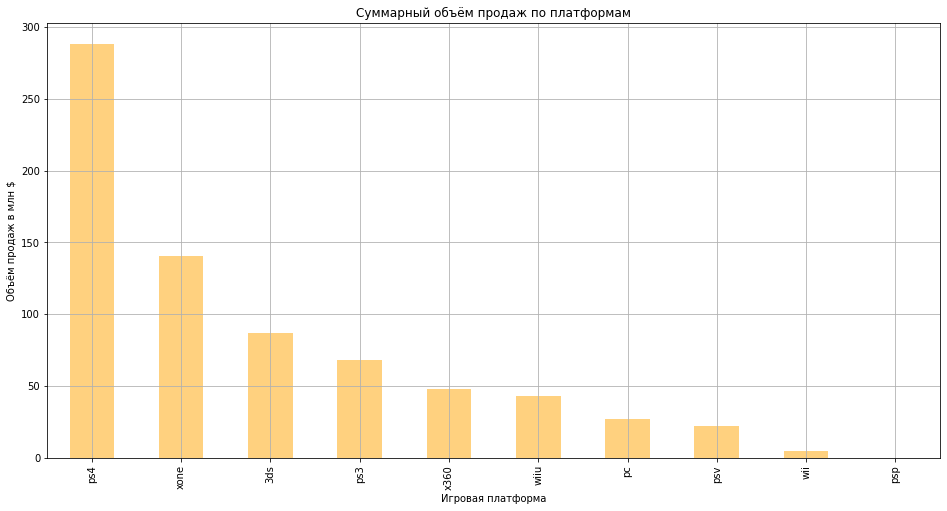

In [105]:
(
    decline_period_data
    .pivot_table(index='platform', values='total_sales', aggfunc='sum')
    .sort_values('total_sales', ascending = False)
    .plot(y='total_sales', kind='bar', figsize=(16, 8), title='Суммарный объём продаж по платформам', grid=True, color='orange', alpha=0.5, legend=False)
    .set(xlabel='Игровая платформа', ylabel='Объём продаж в млн $')
)
plt.show()

<div class="alert alert-info">
<b></b>
<br>Выделим 3 популярные платформы за актуальный период: PS4, Xone, 3DS, т.к. у них самый большой объем продаж за 2014-2016гг..  Дальнейший анализ буду проводить на основе данных платформ.
</div>

In [106]:
# Отфильтруем таблицу и оставлю только строки с топ-3 прибыльными платформами (PS4, Xone, 3DS)
decline_period_data = decline_period_data.query('platform == "ps4" or platform == "xone" or platform == "3ds"')
decline_period_data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,call of duty: black ops 3,ps4,2015,shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,14.63
42,grand theft auto v,ps4,2014,action,3.96,6.31,0.38,1.97,97.0,8.3,m,12.62
47,pokemon omega ruby/pokemon alpha sapphire,3ds,2014,role-playing,4.35,3.49,3.10,0.74,NaN,NaN,unknown,11.68
77,fifa 16,ps4,2015,sports,1.12,6.12,0.06,1.28,82.0,4.3,e,8.58
87,star wars battlefront (2015),ps4,2015,shooter,2.99,3.49,0.22,1.28,NaN,NaN,unknown,7.98
...,...,...,...,...,...,...,...,...,...,...,...,...
16645,zombiu,xone,2016,action,0.00,0.01,0.00,0.00,NaN,NaN,unknown,0.01
16660,prison architect,xone,2016,action,0.01,0.00,0.00,0.00,74.0,6.7,unknown,0.01
16668,fujiko f. fujio characters: great assembly! sl...,3ds,2014,action,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01
16672,metal gear solid v: the definitive experience,xone,2016,action,0.01,0.00,0.00,0.00,NaN,NaN,m,0.01


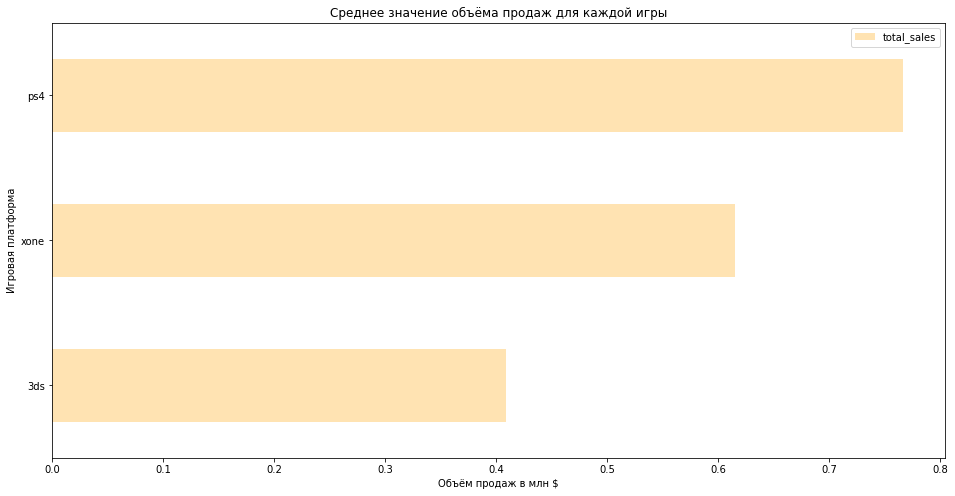

In [107]:
# Строим график среднего объёма продаж для каждой игры для каждой платформы
(
    decline_period_data
    .pivot_table(index="platform", values="total_sales", aggfunc="mean")
    .sort_values('total_sales')
    .plot(kind="barh", title="Среднее значение объёма продаж для каждой игры", color='orange', alpha=0.3, figsize=(16, 8))
    .set(ylabel='Игровая платформа', xlabel='Объём продаж в млн $')
)
plt.show()

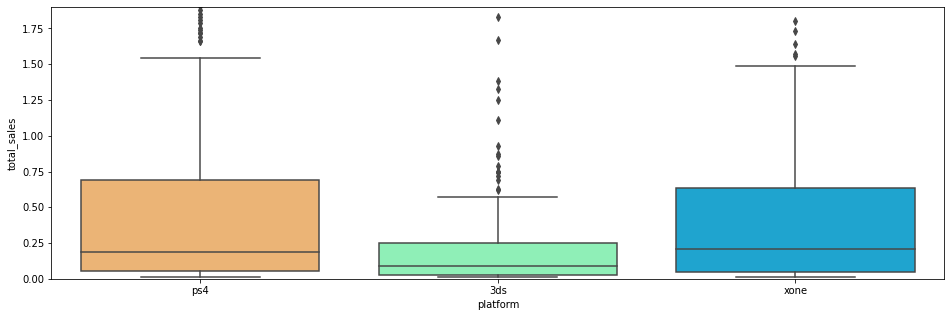

In [108]:
# Строим график "ящик с усами" для каждой платформы (продажи по всем регионам)
plt.rcParams['figure.figsize']=(16, 5)
ax = sns.boxplot(x="platform", y="total_sales", data=decline_period_data, palette='rainbow_r')
ax.set_ylim(0, 1.9)
plt.show()

In [109]:
decline_period_data.groupby('platform')['total_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3ds,212.0,0.408868,1.188368,0.01,0.0300,0.090,0.2500,11.68
ps4,376.0,0.766356,1.614969,0.01,0.0575,0.185,0.6900,14.63
xone,228.0,0.615614,1.046513,0.01,0.0500,0.205,0.6325,7.39


<div class="alert alert-info">
<b></b>
<br>На графике наглядно видно, что для всех 3-х платформ (PS4, Xone, 3DS) медиана расположена примерно на одном уровне (0.185; 0.205; 0.09 млн. долларов), а 3ий квартиль  различается у платформы PS4 он самый большой - 0,69. Таким образом можно сделать вывод, что для платформ Xone и PS4 суммарный объём продаж для каждой игры состоит в диапазоне от 0.05 до 0.75 млн. долларов. А платформа 3DS показывает самые низкие результаты: от 0.03 млн. долларов до 0,25. Данные диапазоны указывают на то, в каком размахе располагается основная масса значений характеризующих суммарный объём продаж для каждой игры.
</div>


Для того, чтобы посмотреть как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков, возьмем наиболее популярную платформу PS4.

In [110]:
#Корреляция между оценками пользователей и продажами 
ps4 = games[games['platform']=='ps4']
ps4['user_score'].corr(ps4['total_sales'])

-0.031957110204556376

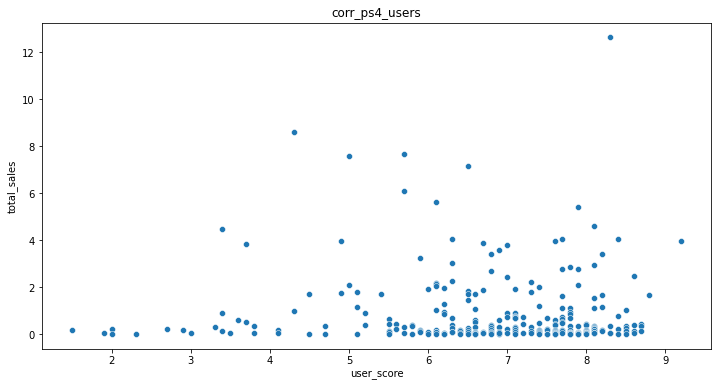

In [111]:
#Построим диаграмму рассеяния
plt.figure(figsize=(12,6))
sns.scatterplot(x='user_score', y='total_sales', data=ps4)
plt.title('corr_ps4_users');

 Зависимость между Отзывами Пользователей и Продажами игр для платформы PS4 - отсутствует, так как коэффициент корреляции составляет -0.032, что в свою очередь означает фактическое отсутствие взаимосвязи данных параметров. 

In [112]:
#Корреляция между оценками критиков и продажами 
ps4 = games[games['platform']=='ps4']
ps4['critic_score'].corr(ps4['total_sales'])

0.40656790206178095

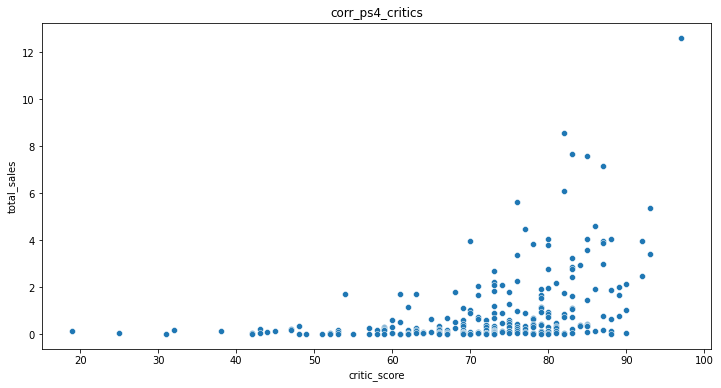

In [113]:
#Построим диаграмму рассеяния по оценкам критиков 
plt.figure(figsize=(12,6))
sns.scatterplot(x='critic_score', y='total_sales', data=ps4)
plt.title('corr_ps4_critics');

Зависимость между Отзывами Критиков и Продажами игр для платформы PS4 - присутствует, но она не очень высокая, так как коэффициент корреляции составляет 0.407, то есть наблюдается зависимость между положительными отзывами и увеличением объёма продаж игр, но зависимость довольна слабая, чтобы утверждать что данные показатели напрямую связаны между собой.

In [114]:
#Корреляция между оценками пользователей и продажами 
xone = games[games['platform']=='xone']
xone['user_score'].corr(xone['total_sales'])

-0.06892505328279414

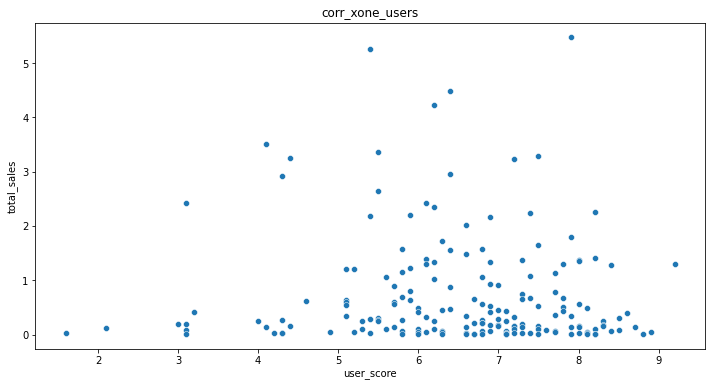

In [115]:
#Построим диаграмму рассеяния
plt.figure(figsize=(12,6))
sns.scatterplot(x='user_score', y='total_sales', data=xone)
plt.title('corr_xone_users');

In [116]:
#Корреляция между оценками критиков и продажами 
xone = games[games['platform']=='xone']
xone['critic_score'].corr(xone['total_sales'])

0.4169983280084017

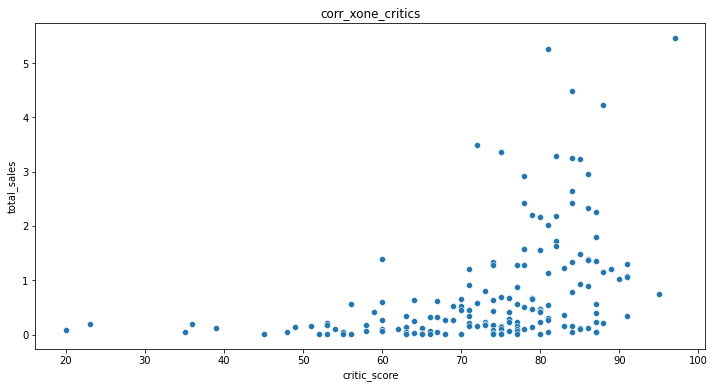

In [117]:
#Построим диаграмму рассеяния по оценкам критиков 
plt.figure(figsize=(12,6))
sns.scatterplot(x='critic_score', y='total_sales', data=xone)
plt.title('corr_xone_critics');

In [118]:
#Корреляция между оценками пользователей и продажами 
_3ds = games[games['platform']=='3ds']
_3ds['user_score'].corr(_3ds['total_sales'])

0.22480798039571082

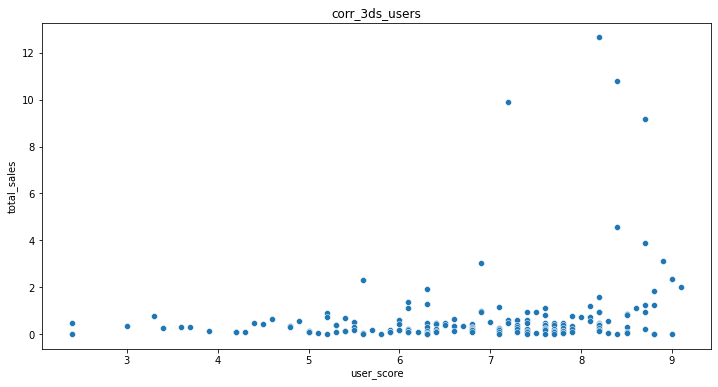

In [119]:
#Построим диаграмму рассеяния
plt.figure(figsize=(12,6))
sns.scatterplot(x='user_score', y='total_sales', data=_3ds)
plt.title('corr_3ds_users');

In [120]:
#Корреляция между оценками критиков и продажами 
_3ds = games[games['platform']=='3ds']
_3ds['critic_score'].corr(_3ds['total_sales'])

0.3494009303924131

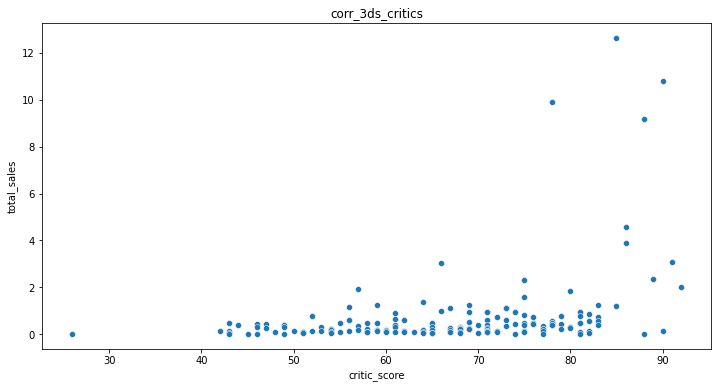

In [121]:
#Построим диаграмму рассеяния по оценкам критиков 
plt.figure(figsize=(12,6))
sns.scatterplot(x='critic_score', y='total_sales', data=_3ds)
plt.title('corr_3ds_critics');

У PS4, Xone, 3DS наблюдается пусть и не сильная, но всё же, связь между оценками критиков и продажами. А связь между оценками пользователей и продажами слабая у всех платформ, либо её совсем нет.

Посмотрим на общее распределение игр по жанрам.

Больше всего игр жанра Action. За ними идут игры спортивного жанра. 

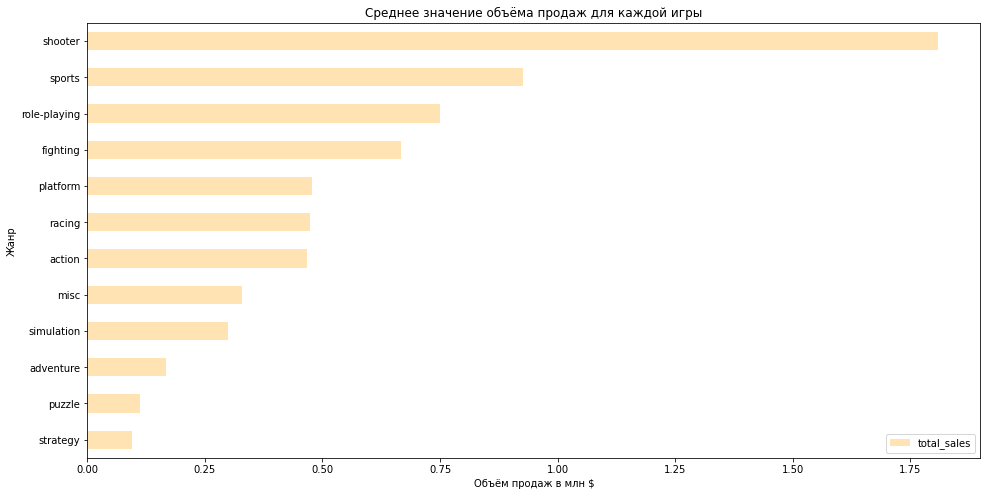

In [122]:
# Строим график среднего объёма продаж для каждой игры для каждого жанра
(
    decline_period_data
    .pivot_table(index="genre", values="total_sales", aggfunc="mean")
    .sort_values('total_sales')
    .plot(kind="barh", title="Среднее значение объёма продаж для каждой игры", color='orange', alpha=0.3, figsize=(16, 8))
    .set(ylabel='Жанр', xlabel='Объём продаж в млн $')
)
plt.show()

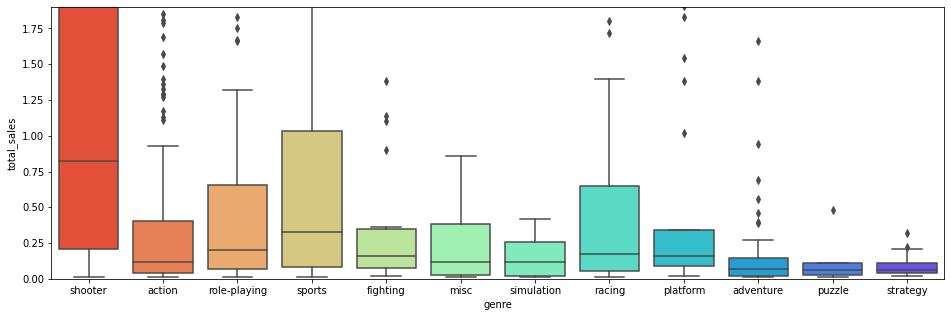

In [123]:
# Строим график "ящик с усами" для каждой платформы (продажи по всем регионам)
plt.rcParams['figure.figsize']=(16, 5)
ax = sns.boxplot(x="genre", y="total_sales", data=decline_period_data, palette='rainbow_r')
ax.set_ylim(0, 1.9)
plt.show()

In [124]:
decline_period_data.groupby('genre')['total_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
genre,,,,,,,,
action,310.0,0.466903,1.076693,0.01,0.0400,0.115,0.4075,12.62
adventure,63.0,0.168095,0.301993,0.01,0.0200,0.070,0.1450,1.66
fighting,27.0,0.666667,1.502749,0.02,0.0750,0.160,0.3500,7.55
misc,56.0,0.327857,0.681788,0.01,0.0300,0.115,0.3800,4.32
platform,21.0,0.477143,0.634115,0.02,0.0900,0.160,0.3400,1.91
puzzle,8.0,0.111250,0.153757,0.01,0.0275,0.065,0.1100,0.48
racing,36.0,0.473611,0.648762,0.01,0.0575,0.175,0.6475,2.42
role-playing,106.0,0.750566,1.629858,0.01,0.0700,0.200,0.6525,11.68
shooter,74.0,1.808784,2.455659,0.01,0.2100,0.820,2.2400,14.63


За анализируемый период больше всего дохода принес жанр shooter, среднее значение почти в 2 раза больше медианы, это значит, в распределении есть длинный хвост с высокими значениями или несколько больших значений, какая-то часть игр приносит больше дохода в этом жанре, чем основная часть. 
Жанр strategy приносит стабильный доход, у него маленькое стандартное отклонение, но объемы продаж низкие.

## Портрет пользователя каждого региона

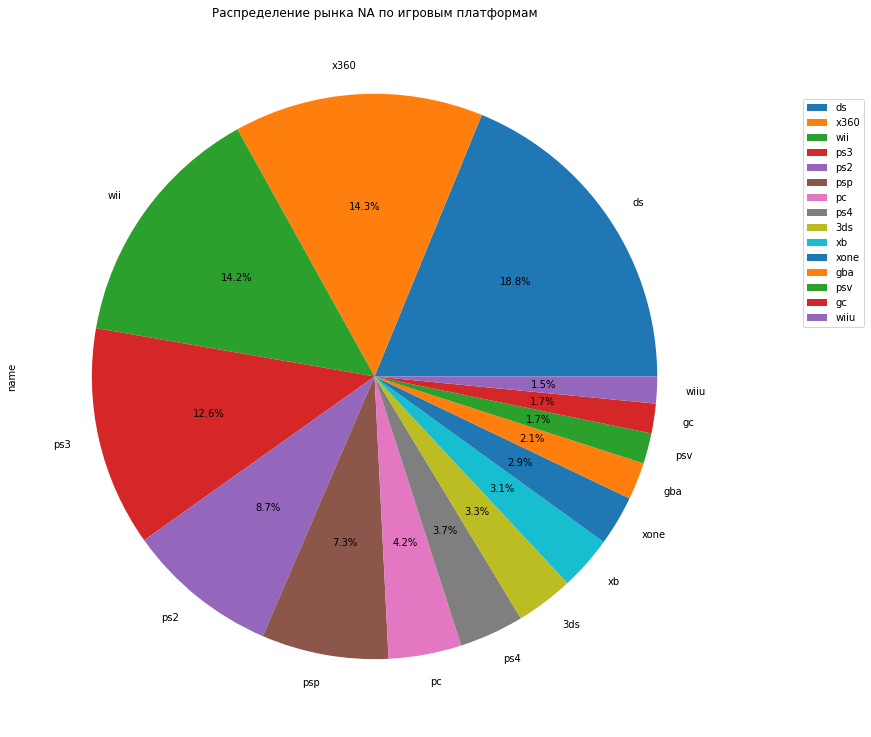

In [102]:
# формируем df со всеми платформами за Актуальный период в регионе NA
game_data_na = games.query('year_of_release >= 2005 and na_sales > 0')

# Рисуем круговую диаграмму популярности всех платформ в регионе NA
(
    game_data_na
    .pivot_table(index="platform", values="name", aggfunc="count")
    .sort_values('name', ascending=False)
    .plot(y="name", kind="pie", figsize=(13, 13), autopct='%1.1f%%')
)
plt.legend(bbox_to_anchor=(0.6, 0, 0.6, 0.9)) # Расположение легенды на графике
plt.title('Распределение рынка NA по игровым платформам') # Название графика
plt.show()

Топ-5 наиболее популярных платформ в регионе NA: 
1. DS: 18.8% от общего объёма рынка
2. X360: 14.3% от общего объёма рынка
3. Wii: 14.2% от общего объёма рынка
4. PS3: 12.6% от общего объёма рынка
5. PS2: 8.7% от общего объёма рынка

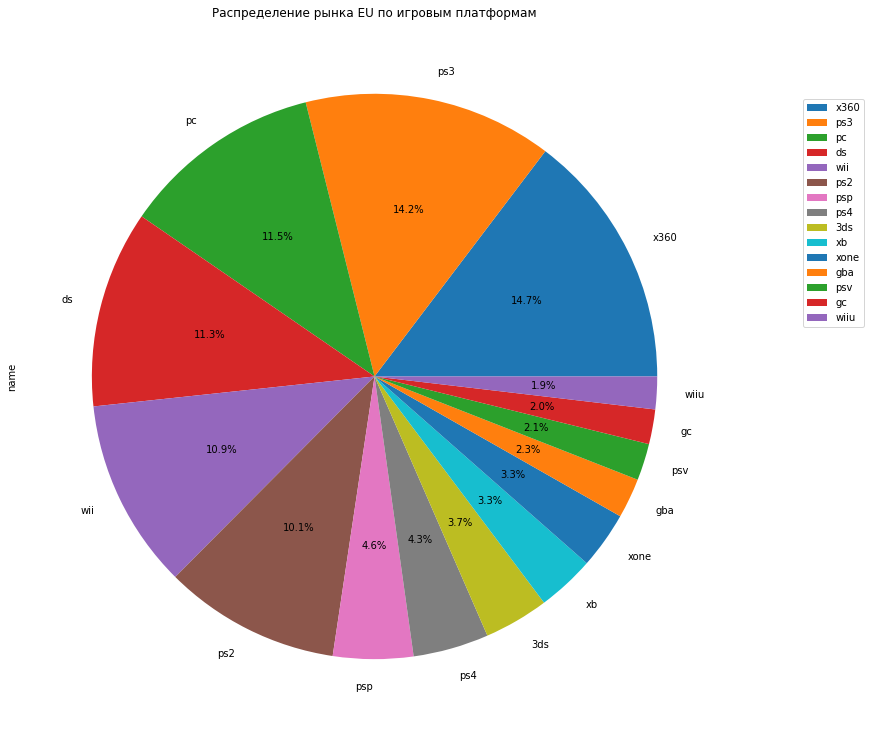

In [103]:
# формируем df со всеми платформами за Актуальный период в регионе EU
game_data_eu = games.query('year_of_release >= 2005 and eu_sales > 0')

# Рисуем круговую диаграмму популярности всех платформ в регионе NA
(
    game_data_eu
    .pivot_table(index="platform", values="name", aggfunc="count")
    .sort_values('name', ascending=False)
    .plot(y="name", kind="pie", figsize=(13, 13), autopct='%1.1f%%')
)
plt.legend(bbox_to_anchor=(0.6, 0, 0.6, 0.9)) # Расположение легенды на графике
plt.title('Распределение рынка EU по игровым платформам') # Название графика
plt.show()

Топ-5 наиболее популярных платформ в регионе EU: 
1. X360: 14.7% от общего объёма рынка
2. PS3: 14.2% от общего объёма рынка
3. PC: 11.5% от общего объёма рынка
4. DS: 11.3% от общего объёма рынка
5. Wii: 10.9% от общего объёма рынка

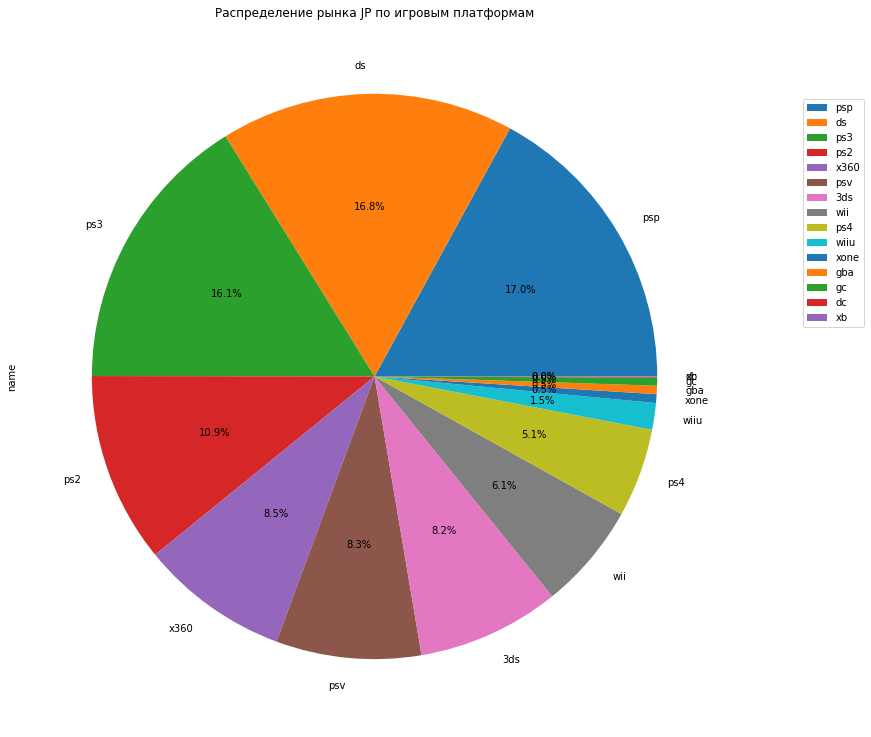

In [61]:
# формируем df со всеми платформами за Актуальный период в регионе JP
game_data_jp = games.query('year_of_release >= 2005 and jp_sales > 0')

# Рисуем круговую диаграмму популярности всех платформ в регионе NA
(
    game_data_jp
    .pivot_table(index="platform", values="name", aggfunc="count")
    .sort_values('name', ascending=False)
    .plot(y="name", kind="pie", figsize=(13, 13), autopct='%1.1f%%')
)
plt.legend(bbox_to_anchor=(0.6, 0, 0.6, 0.9)) # Расположение легенды на графике
plt.title('Распределение рынка JP по игровым платформам') # Название графика
plt.show()

Топ-5 наиболее популярных платформ в регионе JP: 
1. PSP: 17.0% от общего объёма рынка
2. DS: 16.8% от общего объёма рынка
3. PS3: 16.1% от общего объёма рынка
4. PS2: 10.9% от общего объёма рынка
5. X360: 8.5% от общего объёма рынка

In [125]:
# Функция для прорисовки графиков top_in_regions_plot
def top_in_regions_plot(groupby, region_sales, ax):
    pivot = games.groupby(groupby).agg({region_sales: 'sum'}).sort_values(by=region_sales, ascending=False)[:5]
    title_dict = {'na_sales': 'North America Sales', 'eu_sales': 'Europe Sales', 'jp_sales': 'Japan Sales'}
    color_dict = {'na_sales': 'orange', 'eu_sales': 'gray', 'jp_sales': 'forestgreen'}
    plot = pivot.plot(kind='bar', ec='black', title=title_dict[region_sales], ax=axes[ax], 
                   fontsize=18, color=color_dict[region_sales], rot=20)
    plot.legend(prop={'size':17})
    plot.set_xlabel('')
    plot.title.set_size(20)

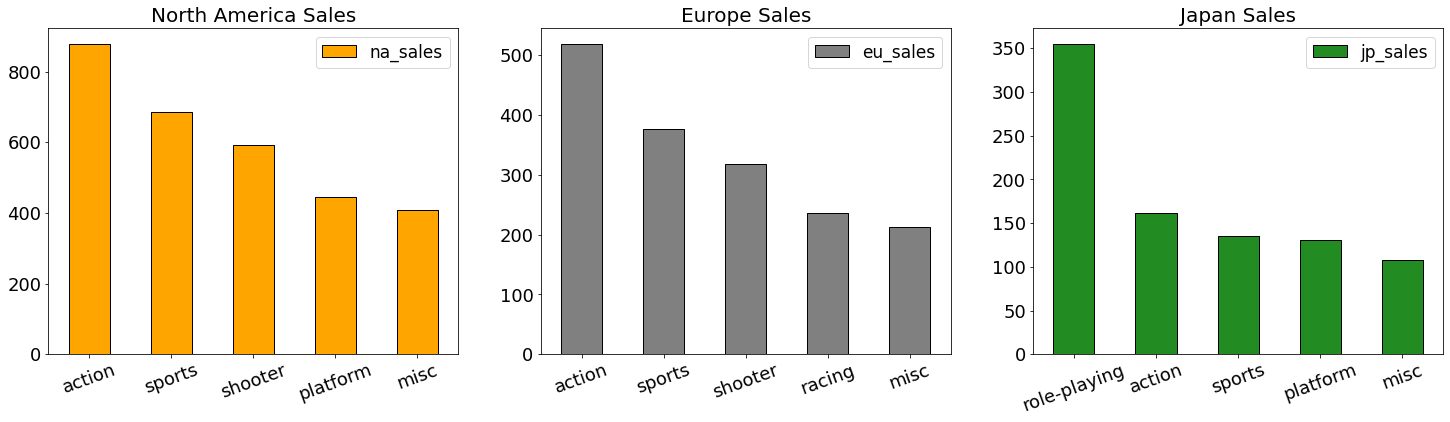

In [126]:
#  Определение самых популярных жанров в заданных регионах
fig, axes = plt.subplots(1, 3, figsize=(25,6))

top_in_regions_plot('genre', 'na_sales', 0)
top_in_regions_plot('genre', 'eu_sales', 1)
top_in_regions_plot('genre', 'jp_sales', 2)

Вкусы в Северной Америке и Европе схожи: и там, и там живут популярны жанры action, sports и shooter. В Северной Америке больше играют в platform, в Европе же чаще выбирают racing.

В Японии вкус совершенно иной - на первом месте role-playing, причем с большим отрывом. Далее action и sports.


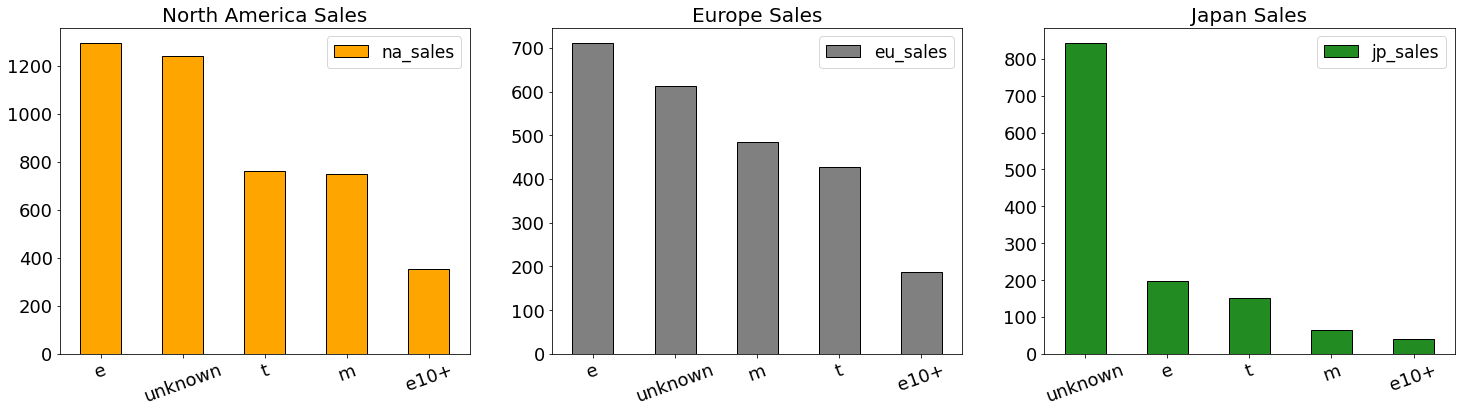

In [127]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))

top_in_regions_plot('rating', 'na_sales', 0)
top_in_regions_plot('rating', 'eu_sales', 1)
top_in_regions_plot('rating', 'jp_sales', 2)

В Северной Америке и в Европе картина практически одинаковая. Большая часть выручки получено с игр с рейтингом E - "Для всех", затем идут игры без рейтинга.

В Японии первое место игры без рейтинга, а вот на втором - E - "Для всех". 

## Проверка гипотез.

Гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Сформулируем нулевые гипотезы:
1. Нулевая гипотеза H₀: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
2. Альтернативная гипотеза H₁: Средние пользовательские рейтинги платформ Xbox One и PC различаются.

Альтернативная гипотеза - утверждение, противоположное нулевой гипотезе. На него мы «соглашаемся» в случае, если
нулевую гипотезу на основе имеющихся данных необходимо отвернуть.

Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, воспользуюсь методом: scipy.stats.ttest_ind().

In [128]:
# Сохраним в переменных xbox_hyp и pc_hyp соответствующие данные (актуальные данные за последние 3 года)
xone_hyp = games[(games['platform']=='xone') & (games['year_of_release']>2013)]['user_score']
pc_hyp = games[(games['platform']=='pc') & (games['year_of_release']>2013)]['user_score']

#Посчитаем средний рейтинг пользователя для xbox платформ
xone_hyp.mean()

6.594545454545454

In [129]:
#Посчитаем средний рейтинг пользователя для PC платформ
pc_hyp.mean()

6.316260162601626

In [130]:
# Произведем проверку дисперсии выборок
np.var(games[games['platform']=='xone']['user_score'])

1.8965188383045526

In [131]:
np.var(games[games['platform']=='pc']['user_score'])

2.3377471580367684

In [132]:
#Выполним проверку гипотезы. Будем использовать метод ttest_ind

alpha = .05

results = st.ttest_ind(xone_hyp.dropna(), pc_hyp.dropna(), equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.139237120435483
Не получилось отвергнуть нулевую гипотезу


Верно следующее утверждение: средние пользовательские рейтинги платформ Xbox One и PC отличаются между собой.

Гипотеза: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Сформулируем нулевые гипотезы:
1. Нулевая гипотеза H₀: Средние пользовательские рейтинги жанров Action и Sports одинаковые.
2. Альтернативная гипотеза H₁: Средние пользовательские рейтинги жанров Action и Sports различаются.

In [133]:
# Сохраним в переменных genre_action_hyp и genre_sports_hyp соответствующие данные с пользовательскими оценками
genre_action_hyp = games[(games['genre']=='action') & (games['year_of_release']>2005)]['user_score']
genre_sports_hyp = games[(games['genre']=='sports') & (games['year_of_release']>2005)]['user_score']

#выведем среднюю оценку по жанру action
genre_action_hyp.mean()

6.881012658227848

In [134]:
#выведем среднюю оценку по жанру спорт
genre_sports_hyp.mean()

6.418621700879766

In [135]:
# Произведем проверку дисперсии выборок
np.var(games[games['genre']=='action']['user_score'])

2.0306366538266296

In [136]:
np.var(games[games['genre']=='sports']['user_score'])

2.5941606711770175

In [137]:
#Выполним проверку гипотезы. Будем использовать метод ttest_ind

alpha = .01

results = st.ttest_ind(genre_action_hyp.dropna(), genre_sports_hyp.dropna(), equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.759403504326082e-10
Отвергаем нулевую гипотезу


Отвергли нулевую гипотезу, таким образом, у нас практически нет вероятности получить одинакове средние рейнтинги по двум жанрам.

## Вывод

До 1994 года игр практически не было. Потом они начали появляться, сначала на MS-DOS, потом уже на Windows. Резкий скачок по количеству игр, выпущенных в год, произошел в 2002 году. Пик - 2008-2009 года. После этого начался спад, связанный с развитием мобильных устройств, интеграция соц. сетей в жизнь людей. Это всё привело к тому, что интерес к самим играм упал, соответственно, упало и их производство.

В среднем платформы для видеогр существуют 10 лет. В среднем актвные продажи платформ длятся 5 лет.

В период 2014-2016гг. было 3 популярных платформ: PS4, Xone, 3DS. Для всех 3-х платформ (PS4, Xone, 3DS) медиана расположена примерно на одном уровне (0.185; 0.205; 0.09 млн. долларов), а 3ий квартиль  различается у платформы PS4 он самый большой - 0,69. Таким образом можно сделать вывод, что для платформ Xone и PS4 суммарный объём продаж для каждой игры состоит в диапазоне от 0.05 до 0.75 млн. долларов. А платформа 3DS показывает самые низкие результаты: от 0.03 млн. долларов до 0,25. Данные диапазоны указывают на то, в каком размахе располагается основная масса значений характеризующих суммарный объём продаж для каждой игры.

У PS4, Xone, 3DS наблюдается пусть и не сильная, но всё же, связь между оценками критиков и продажами. А связь между оценками пользователей и продажами слабая у всех платформ, либо её совсем нет.

Наиболее популярны платформы для видеоигр в Северной америке: DS-18.8%, X360-14.3%, Wii-14.2%, в Европе: X360-14.7%, PS3-14.2%, PC-11.5% доли популярности платформ в Европе практически не отличаются, в Японии: PSP -17%, DS-16.8%, PS-16.1%. Вкусы в Северной Америке и Европе схожи: и там, и там живут популярны жанры action, sports и shooter. В Северной Америке больше играют в platform, в Европе же чаще выбирают racing. В Японии вкус совершенно иной - на первом месте role-playing, причем с большим отрывом. Далее action и sports. В Северной Америке и в Европе картина практически одинаковая. Большая часть выручки получено с игр с рейтингом E - "Для всех", затем идут игры без рейтинга. В Японии первое место игры без рейтинга, а вот на втором - E - "Для всех". 
